In [1]:
import heeps

### 1. Create a config dictionary with your simulation parameters in read_config

In [2]:
conf = dict(
    dir_current = '$HOME/heeps_metis',  # specify a directory (current directory by default)
    nframes = 10,                       # number of frames selected from the SCAO phase screens
    f_phase = 'wavefront/COMPASS_201810_RandomWind_100screens_meters.fits',
    f_pupil = 'pupil/ELT_fullM1.fits',  # entrance pupil file
)
conf = heeps.config.read_config(verbose=False, **conf)

### 2. Update config parameters. The following parameters will be updated to match the selected spectral band and HCI mode:
lam, pscale, flux_star, flux_bckg, ls_dRspi, ls_dRint, npupil, ndet, ravc_t, ravc_r

In [3]:
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf) 

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2568
   ravc_calc=True, ravc_t=0.7608, ravc_r=0.6213
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   hfov=1.1 arcsec (-> ndet=403, 51.74 lam/D)



### 3. Load entrance pupil, and create 'wavefront' object

In [4]:
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

Load pupil from 'ELT_fullM1.fits'


### 4. Load wavefront errors

In [5]:
phase_screens, amp_screens, tiptilts, misaligns = heeps.wavefront.load_errors(verbose=True, **conf)

Load phase screens from 'COMPASS_201810_RandomWind_100screens_meters.fits'
   nscreens=10 (nframes=10, nstep=1)


### 5. Propagate one frame of offaxis psf (i.e. planet)

In [6]:
psf = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=True, verbose=True, **conf)

Create single off-axis PSF
   apply ring apodizer: ravc_t=0.7608, ravc_r=0.6213
   apply lyot stop from 'ls_ravc_allglass_285.fits'
   extract PSF on the detector: ndet=403


### 6. Propagate cube of onaxis psfs (i.e. star)

In [7]:
psfs = heeps.wavefront.propagate_cube(wf, phase_screens=phase_screens, \
    amp_screens=amp_screens, tiptilts=tiptilts, misaligns=misaligns, onaxis=True, \
    savefits=True, verbose=True, **conf)

Create on-axis PSF cube
   2021-09-23 10:50:01, e2e simulation using 12 cores
   2021-09-23 10:50:07, completed in 6.28 seconds


### 7. Produce 5-sigma sensitivity (contrast) curves for each set of PSFs (modes, bands)

In [8]:
sep, sen = heeps.contrast.adi_one(savepsf=True, savefits=True, verbose=True, **conf)

Load PSFs for ADI
   mode=RAVC, band=L
   ncube=10, ndet=403
   pscale=5.47 mas, dit=0.3 s
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2021-09-23 10:50:08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : median_sub, FWHM = 3.1433897299876428, # BRANCHES = 1, SIGMA = 5, STARPHOT = 100000000000.0
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Finished the throughput calculation
Running time:  0:00:07.198518
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


### 8. Create a figure 

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

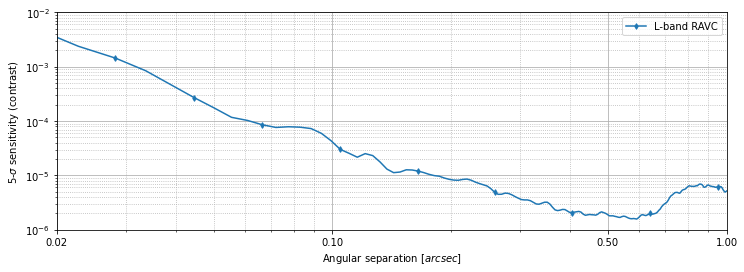

In [10]:
savename = 'ADI_contrast_curve.png'
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog(), plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xlabel('Angular separation $[arcsec]$')
plt.ylabel('5-$\sigma$ sensitivity (contrast)')
label = '%s-band %s'%(conf['band'], conf['mode'])
plt.plot(sep, sen, label=label, marker='d', markevery=0.12, markersize=4)
plt.legend()
plt.xticks([0.02, 0.1, 0.5, 1])
plt.xlim(0.02,1)
plt.ylim(1e-6,1e-2)
plt.savefig('%s/%s'%(conf['dir_output'], savename), dpi=300, transparent=True)